In [1]:
import pickle
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean
import scipy
import sklearn
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
import re
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files/new"

In [2]:
df = pd.read_stata(fpath + "/full_data_truncated.dta")

In [3]:
from collections import Counter
Counter(df[df.valid==1].first_nonde_strm)

Counter({2123.0: 8385, 2124.0: 38489, 2132.0: 15744})

In [4]:
to_drop = [p for p in df.columns.values if 'pell' in p]
df = df.drop(to_drop, axis=1)
df.shape

(385800, 305)

In [5]:
# new_demo = pd.read_stata("C:/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files/bias/new_student_demographics.dta")
# df = df.merge(new_demo, on=['vccsid'], how='inner')
# df.shape

In [6]:
predictors = list(df.columns)[10:]
predictors = [p for p in predictors if p != "age_strm"]
print(len(predictors))
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "lvl2_prop_comp", "dev_prop_comp"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

294


In [7]:
predictors

['available_fa1',
 'available_fa2',
 'available_fa3',
 'available_fa4',
 'available_fa5',
 'available_fa6',
 'available_sp1',
 'available_sp2',
 'available_sp3',
 'available_sp4',
 'available_sp5',
 'available_sp6',
 'available_su1',
 'available_su2',
 'available_su3',
 'available_su4',
 'available_su5',
 'available_su6',
 'withdrawn_prop_comp',
 'lvl2_prop_comp',
 'dev_prop_comp',
 'prop_comp',
 'prop_comp_sd',
 'withdrawn_prop_comp_sd',
 'college_entropy',
 'age_entry',
 'male',
 'white',
 'afam',
 'hisp',
 'asian',
 'other',
 'phe_1',
 'phe_2',
 'phe_3',
 'phe_4',
 'phe_5',
 'phe_6',
 'phe_7',
 'dual_ind',
 'seamless_enrollee_0',
 'seamless_enrollee_1',
 'program_chng_ind',
 'enrolled_pre',
 'coll_lvl_cred_earn',
 'prop_comp_pre',
 'cum_gpa_pre',
 'pre_num_nsc_coll',
 'num_nsc_coll',
 'pre_nsc_terms',
 'nsc_terms',
 'cum_gpa',
 'repeat_ind',
 'enrl_intensity_trend',
 'gpa_trend',
 'enrolled_fa1',
 'degree_seeking_fa1',
 'term_cred_att_fa1',
 'term_gpa_fa1',
 'prop_comp_fa1',
 'withd

In [10]:
df[df.enrolled_pre == 0].cum_gpa_pre.describe()

count    331894.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: cum_gpa_pre, dtype: float64

In [7]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(323182, 305) (62618, 305)


In [8]:
# degree completion rate of whole sample
sum(df.grad_6years)/df.shape[0]

0.34022809745982374

In [9]:
# degree completion rate of train sample
sum(train_df.grad_6years)/train_df.shape[0]

0.34003131362514

In [10]:
# degree completion rate of validation sample
sum(test_df.grad_6years)/test_df.shape[0]

0.34124373183429685

In [11]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test                    

In [12]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\bias\\new\\"

#### (1) Run the basic version of logistic regression

In [14]:
lr = sm.Logit(y_train, add_constant(X_train,prepend=True)).fit()

Optimization terminated successfully.
         Current function value: 0.406748
         Iterations 9


In [15]:
y_test_pred_lr = list(lr.predict(add_constant(X_test, prepend=True)))
print("Logistic Regression:")
print("AUC = {}".format(round(roc_auc_score(y_test, y_test_pred_lr),4)))

Logistic Regression:
AUC = 0.8945


In [16]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(lr, open(fpath + "/lr.p", "wb"))
pickle.dump(list(y_test_pred_lr), open(results_dir + "y_test_pred_lr.p", "wb"))

In [17]:
# y_test_pred_lr = pickle.load(open(fpath + "/y_test_pred_lr.p", "rb"))

In [18]:
lr_summary = pd.DataFrame({'coef': lr.params, 'std_err': lr.bse, 'p-values': lr.pvalues}, index=lr.params.index).loc[:,['coef','std_err','p-values']]
lr_summary.to_csv(results_dir + "lr_summary.csv", index=True)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [19]:
y_train_pred_lr = list(lr.predict(add_constant(X_train, prepend=True)))

In [20]:
# def find_optimal_threshold(p,r,t):
#     to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
#     to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
#     to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
#     p,r,t = p[to_keep],r[to_keep],t[to_keep]
#     to_keep_2 = np.where(t < 0.8)[0]
#     p,r,t = p[to_keep_2],r[to_keep_2],t[to_keep_2]
#     f1 = 2*p*r/(p+r)
#     best_t = t[np.argmax(f1)]
#     return best_t

In [21]:
# def cross_validation_lr(train):
#     threshold_list = []
#     auc_list = []
#     k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
#     for train_indices, test_indices in k_fold.split(train, train.grad_6years):
#         train_part = train.iloc[train_indices,:]
#         test_part = train.iloc[test_indices,:]
#         train_part_new, test_part_new = impute(train_part, test_part)
#         X_1 = train_part_new.loc[:,predictors]
#         y_1 = train_part_new.grad_6years
#         X_2 = test_part_new.loc[:,predictors]
#         y_2 = test_part_new.grad_6years
#         model = sm.Logit(y_1, add_constant(X_1,prepend=True)).fit()
#         p,r,t = precision_recall_curve(y_2, model.predict(add_constant(X_2, prepend=True)))
#         auc = roc_auc_score(y_2, model.predict(add_constant(X_2, prepend=True)))
#         threshold_list.append(find_optimal_threshold(p,r,t))
#         auc_list.append(auc)
#     print(threshold_list)
#     print(np.mean(auc_list), np.std(auc_list, ddof=1))
#     return gmean(threshold_list)                                  

In [22]:
sr = np.mean(y_train)
n = int(X_train.shape[0] - X_train.shape[0] * sr)
best_threshold = sorted(y_train_pred_lr)[n-1]
# best_threshold = cross_validation_lr(train_df)

In [23]:
best_threshold

0.4501129104516566

In [24]:
print("Balanced accuracy score = {}".format(round(balanced_accuracy_score(y_test, np.where(np.array(y_test_pred_lr) > best_threshold, 1, 0)), 4)))

Balanced accuracy score = 0.8166


In [25]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [26]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_lr = create_confusion_matrix(np.array(y_test_pred_lr), best_threshold, "LR_cm")
pr_lr

F1 threshold = 0.45:

         Pred_0   Pred_1         
Real_0  35775.0   5475.0  41250.0
Real_1   5000.0  16368.0  21368.0
        40775.0  21843.0  62618.0

F1 score = 0.7576


(0.7493476170855652,
 0.7660052414825907,
 0.8773758430410791,
 0.8672727272727273,
 0.7576)

#### 1st_year vs. 2+ years

In [27]:
def two_side_z_test(n1, p1, n2, p2):
    z = (p2-p1)/np.sqrt(p2*(1-p2)/(n2-1)+p1*(1-p1)/(n1-1))
    return 2*(1-scipy.stats.norm.cdf(np.abs(z)))

def two_side_z_test_2(n1, p1, v1, n2, p2, v2):
    z = (p2-p1)/np.sqrt(v2/n2+v1/n1)
    return 2*(1-scipy.stats.norm.cdf(np.abs(z)))

In [28]:
test_df.loc[:,'available_sum'] = 0
for p in [p for p in list(test_df.columns)[10:] if p.startswith("available") and p != "available_sum"]:
    test_df.loc[:,'available_sum'] += test_df[p]

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
first_year_ind = (test_df.available_sum <= 3).astype(int)
first_term_ind = (test_df.available_sum <= 1).astype(int)

In [30]:
print("AUC first-year = {}".format(round(roc_auc_score(np.array(y_test)[first_year_ind == 1], np.array(y_test_pred_lr)[first_year_ind == 1]),4)))
print("AUC non-first-year = {}".format(round(roc_auc_score(np.array(y_test)[first_year_ind == 0], np.array(y_test_pred_lr)[first_year_ind == 0]),4)))

AUC first-year = 0.88
AUC non-first-year = 0.8841


In [31]:
print("AUC first-term = {}".format(round(roc_auc_score(np.array(y_test)[first_term_ind == 1], np.array(y_test_pred_lr)[first_term_ind == 1]),4)))
print("AUC non-first-term = {}".format(round(roc_auc_score(np.array(y_test)[first_term_ind == 0], np.array(y_test_pred_lr)[first_term_ind == 0]),4)))

AUC first-term = 0.8608
AUC non-first-term = 0.8902


In [32]:
ps_df = pd.DataFrame({'test_y': np.array(y_test), 'pred_y': np.array(y_test_pred_lr),
                      'first_year_ind': first_year_ind, 'first_term_ind': first_term_ind})
ps_df.to_csv(results_dir + "pred_score_by_first_yearterm.csv", index=False)

In [33]:
bas_1 = balanced_accuracy_score(np.array(y_test)[first_term_ind == 1], np.where(np.array(y_test_pred_lr)[first_term_ind == 1] > best_threshold, 1, 0))
bas_0 = balanced_accuracy_score(np.array(y_test)[first_term_ind == 0], np.where(np.array(y_test_pred_lr)[first_term_ind == 0] > best_threshold, 1, 0))
print(bas_0)
print(bas_1)
print(two_side_z_test(sum(first_term_ind == 0),bas_0,sum(first_term_ind == 1),bas_1))

0.8150531065915687
0.7233339827992118
0.0


In [34]:
bas_1 = balanced_accuracy_score(np.array(y_test)[first_year_ind == 1], np.where(np.array(y_test_pred_lr)[first_year_ind == 1] > best_threshold, 1, 0))
bas_0 = balanced_accuracy_score(np.array(y_test)[first_year_ind == 0], np.where(np.array(y_test_pred_lr)[first_year_ind == 0] > best_threshold, 1, 0))
print(bas_0)
print(bas_1)
print(two_side_z_test(sum(first_year_ind == 0),bas_0,sum(first_year_ind == 1),bas_1))

0.8081045498813777
0.7771531510917836
0.0


#### 1st_term: white vs. afam 

In [35]:
white = np.where(np.array((np.array(test_df.available_sum) <= 1) & (np.array(test_df.white) == 1)) == True) [0]
afam = np.where(np.array((np.array(test_df.available_sum) <= 1) & (np.array(test_df.afam) == 1)) == True) [0]
hisp = np.where(np.array((np.array(test_df.available_sum) <= 1) & (np.array(test_df.hisp) == 1)) == True) [0]
asian = np.where(np.array((np.array(test_df.available_sum) <= 1) & (np.array(test_df.asian) == 1)) == True) [0]
other = np.where(np.array((np.array(test_df.available_sum) <= 1) & (np.array(test_df.other) == 1)) == True) [0]

In [36]:
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[white], np.array(y_test_pred_lr)[white]),4)))
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[afam], np.array(y_test_pred_lr)[afam]),4)))
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[hisp], np.array(y_test_pred_lr)[hisp]),4)))
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[asian], np.array(y_test_pred_lr)[asian]),4)))
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[other], np.array(y_test_pred_lr)[other]),4)))

AUC = 0.8625
AUC = 0.852
AUC = 0.8361
AUC = 0.8302
AUC = 0.8876


In [37]:
bas_0 = balanced_accuracy_score(np.array(y_test)[white], np.where(np.array(y_test_pred_lr)[white] > best_threshold, 1, 0))
print(bas_0)
for r in ['afam', 'hisp', 'asian', 'other']:
    bas_1 = balanced_accuracy_score(np.array(y_test)[eval(r)], np.where(np.array(y_test_pred_lr)[eval(r)] > best_threshold, 1, 0))
    print(bas_1, two_side_z_test(len(white),bas_0,len(eval(r)),bas_1))

0.7410146135396322
0.6821050601049989 3.1186164761720647e-12
0.6912989921612542 0.0002336346354350205
0.7262404262404263 0.45568021936473935
0.7170333782367909 0.20036635363589284


In [38]:
test_df_one_term = test_df[test_df.available_sum == 1].copy()

In [39]:
race_column = []
for i in range(test_df_one_term.shape[0]):
    if test_df_one_term.white.iloc[i] == 1:
        race_column.append("white")
    elif test_df_one_term.afam.iloc[i] == 1:
        race_column.append("afam")
    elif test_df_one_term.hisp.iloc[i] == 1:
        race_column.append("hisp")
    elif test_df_one_term.asian.iloc[i] == 1:
        race_column.append("asian")
    elif test_df_one_term.other.iloc[i] == 1:
        race_column.append("other")
    else:
        race_column.append("mi")
race_column = np.array(race_column)
pred_y = np.array(y_test_pred_lr)[np.array(test_df.available_sum == 1)]
test_y = np.array(test_df_one_term.grad_6years)
pred_y = pred_y[race_column != "mi"]
test_y = test_y[race_column != "mi"]
race_column = race_column[race_column != "mi"]
print(len(race_column), len(pred_y), len(test_y))

14678 14678 14678


In [40]:
pred_score_by_race = pd.DataFrame({'race_column': race_column, 'pred_y': pred_y, 'test_y': test_y})
pred_score_by_race.to_csv(results_dir + "pred_score_by_race_full_1st.csv", index=False)

In [41]:
white = np.where(np.array((np.array(test_df.available_sum) > 1) & (np.array(test_df.white) == 1)) == True) [0]
afam = np.where(np.array((np.array(test_df.available_sum) > 1) & (np.array(test_df.afam) == 1)) == True) [0]
hisp = np.where(np.array((np.array(test_df.available_sum) > 1) & (np.array(test_df.hisp) == 1)) == True) [0]
asian = np.where(np.array((np.array(test_df.available_sum) > 1) & (np.array(test_df.asian) == 1)) == True) [0]
other = np.where(np.array((np.array(test_df.available_sum) > 1) & (np.array(test_df.other) == 1)) == True) [0]

In [42]:
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[white], np.array(y_test_pred_lr)[white]),4)))
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[afam], np.array(y_test_pred_lr)[afam]),4)))
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[hisp], np.array(y_test_pred_lr)[hisp]),4)))
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[asian], np.array(y_test_pred_lr)[asian]),4)))
print("AUC = {}".format(round(roc_auc_score(np.array(y_test)[other], np.array(y_test_pred_lr)[other]),4)))

AUC = 0.8873
AUC = 0.8771
AUC = 0.8913
AUC = 0.8877
AUC = 0.8836


In [43]:
test_df_two_term = test_df[test_df.available_sum > 1].copy()

In [44]:
race_column = []
for i in range(test_df_two_term.shape[0]):
    if test_df_two_term.white.iloc[i] == 1:
        race_column.append("white")
    elif test_df_two_term.afam.iloc[i] == 1:
        race_column.append("afam")
    elif test_df_two_term.hisp.iloc[i] == 1:
        race_column.append("hisp")
    elif test_df_two_term.asian.iloc[i] == 1:
        race_column.append("asian")
    elif test_df_two_term.other.iloc[i] == 1:
        race_column.append("other")
    else:
        race_column.append("mi")
race_column = np.array(race_column)
pred_y = np.array(y_test_pred_lr)[np.array(test_df.available_sum > 1)]
test_y = np.array(test_df_two_term.grad_6years)
pred_y = pred_y[race_column != "mi"]
test_y = test_y[race_column != "mi"]
race_column = race_column[race_column != "mi"]
print(len(race_column), len(pred_y), len(test_y))

47371 47371 47371


In [45]:
pred_score_by_race = pd.DataFrame({'race_column': race_column, 'pred_y': pred_y, 'test_y': test_y})
pred_score_by_race.to_csv(results_dir + "pred_score_by_race_full_non_1st.csv", index=False)

#### Check demographic parity

In [44]:
import matplotlib
font = {'size': 24}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

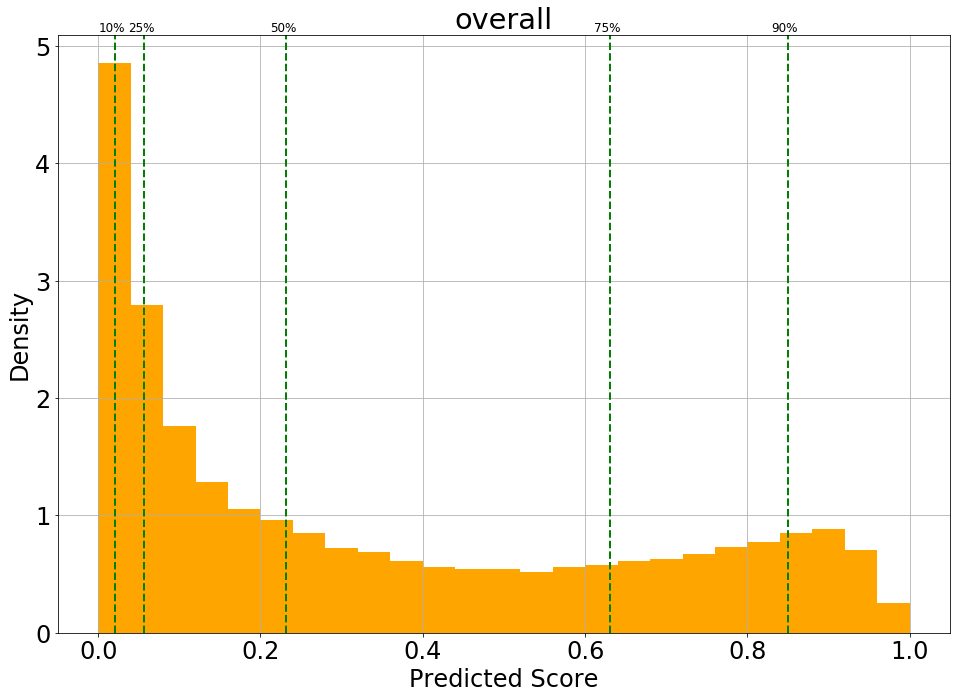

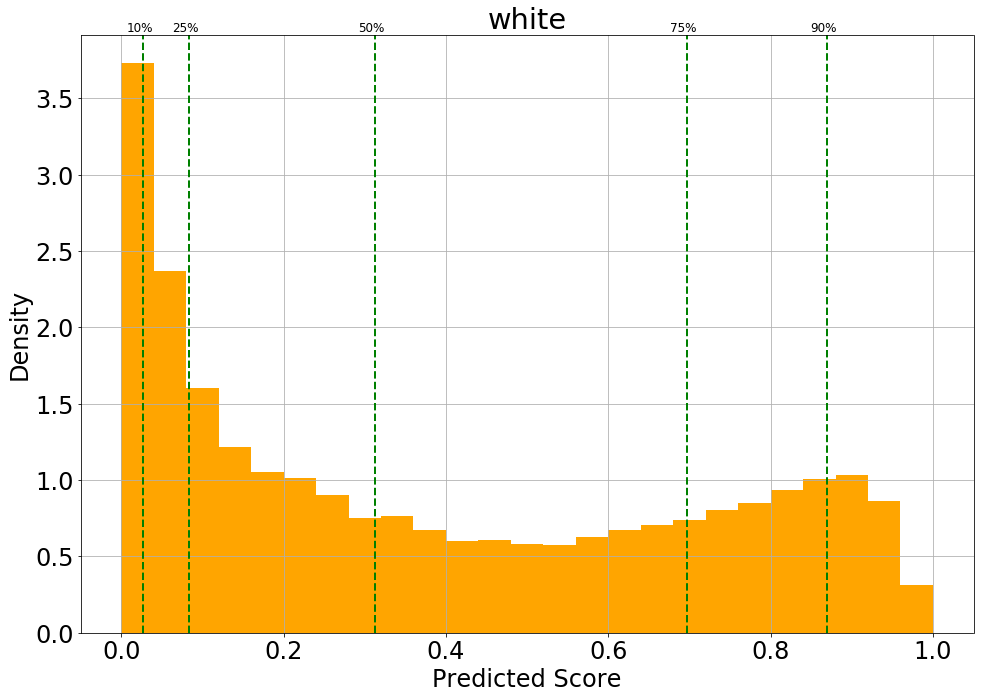

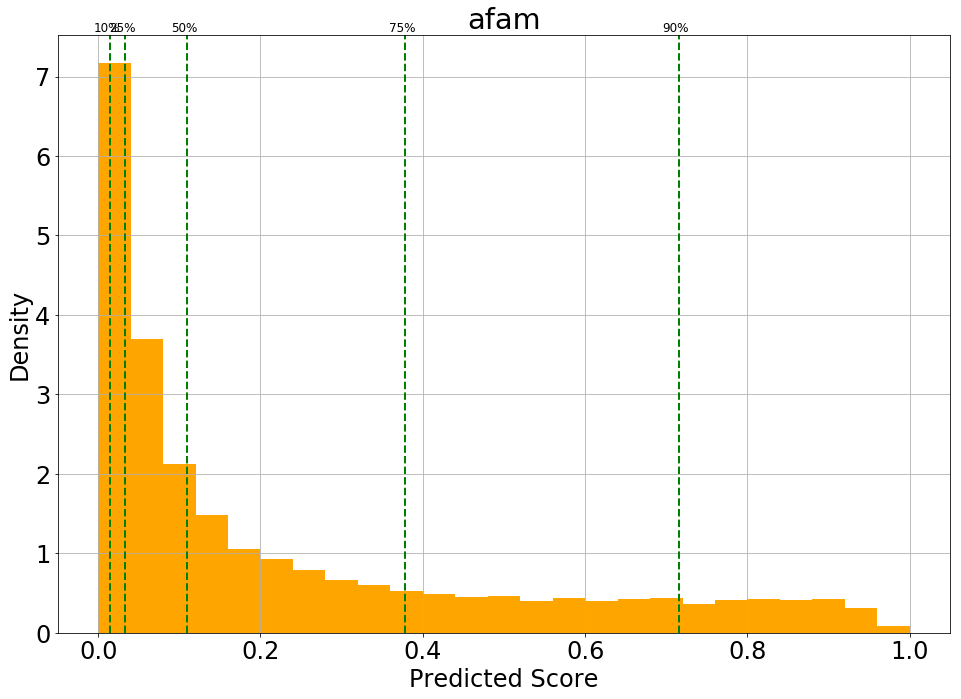

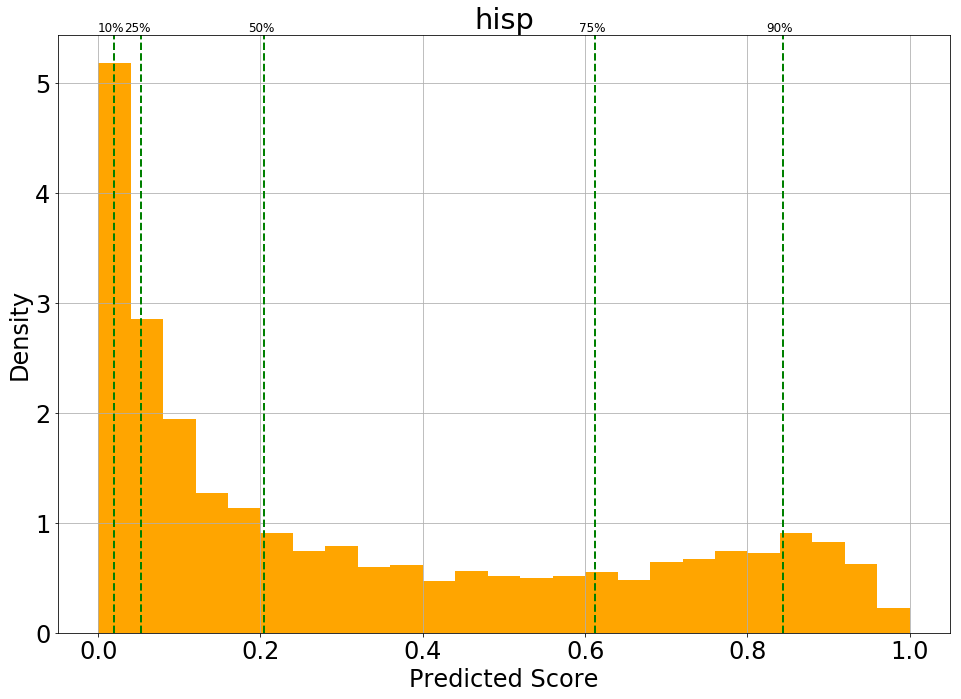

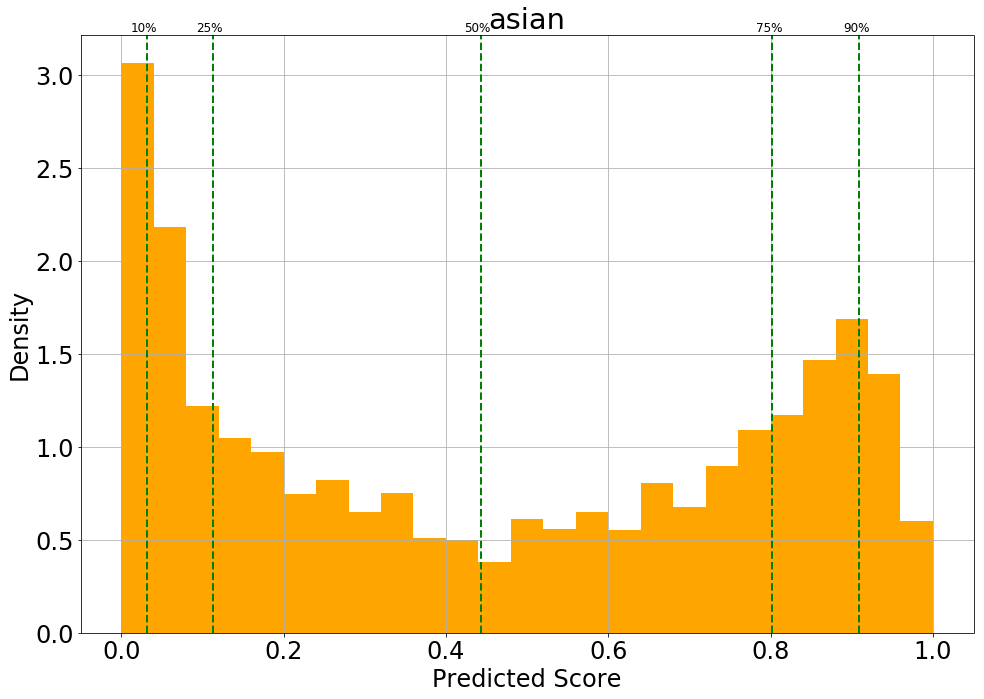

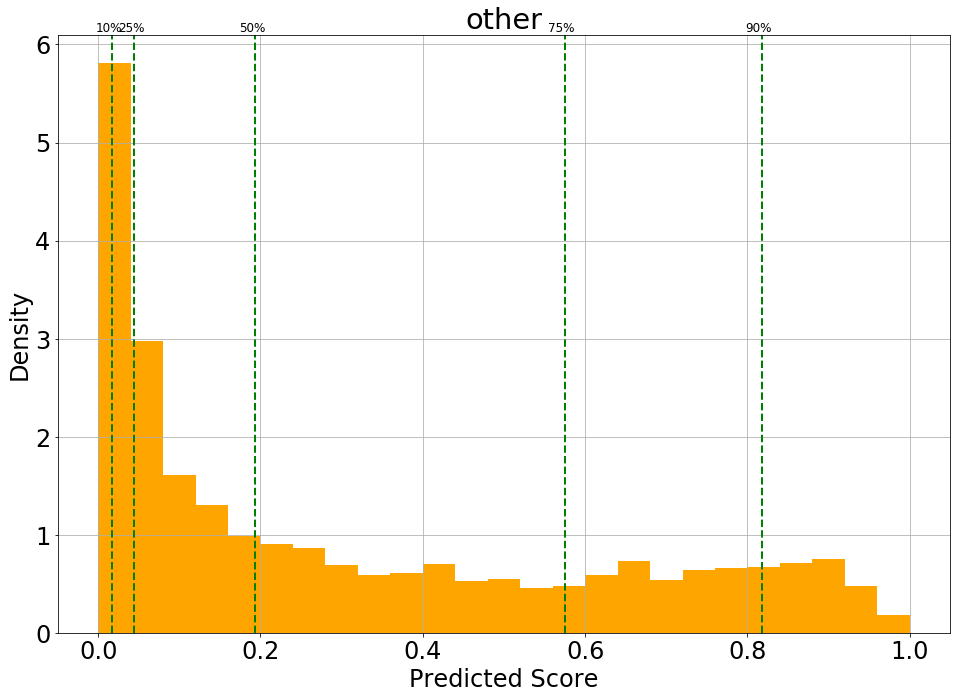

In [45]:
success_rate_1 = []
for r in ['overall', 'white', 'afam', 'hisp', 'asian', 'other']:
    if r == 'overall':
        y_arr = np.array(y_test_pred_lr)
        y_actual = np.array(test_df.grad_6years)
    else:
        y_arr = np.array(y_test_pred_lr)[np.where(np.array(test_df[r]) == 1)[0]]
        y_actual = np.array(test_df.grad_6years)[np.where(np.array(test_df[r]) == 1)[0]]
    success_rate_1.append((r, len(y_arr), np.mean(y_actual), np.mean(y_arr > best_threshold)))
    fig = plt.figure(figsize=(16,11)) 
    ax = fig.add_subplot(1, 1, 1)
    pd.DataFrame({r:y_arr}).hist(r, bins = np.linspace(0,1,26), density=True, color='orange', figsize=(16,11), ax=ax)
    for p,q in zip(np.percentile(y_arr, q = [10,25,50,75,90]), [10,25,50,75,90]):
        ax.axvline(x=p, color='g', linestyle='dashed', linewidth=2)
        ax.text(p-0.02,ax.get_ylim()[1]*1.005,"{}%".format(q),fontsize=12)
    ax.set_xlabel("Predicted Score")
    ax.set_ylabel("Density")
    plt.savefig(results_dir + r +"_1.png")
    plt.show()

In [46]:
n1 = success_rate_1[1][1]
p1 = success_rate_1[1][2]
asr_pval = []
for i in range(2, len(success_rate_1)):
    subgp = success_rate_1[i][0]
    n2 = success_rate_1[i][1]
    p2 = success_rate_1[i][2]
    asr_pval.append((subgp, two_side_z_test(n1,p1,n2,p2)))
n1 = success_rate_1[1][1]
p1 = success_rate_1[1][3]
psr_pval = []
for i in range(2, len(success_rate_1)):
    subgp = success_rate_1[i][0]
    n2 = success_rate_1[i][1]
    p2 = success_rate_1[i][3]
    psr_pval.append((subgp, two_side_z_test(n1,p1,n2,p2)))

In [47]:
pd.DataFrame(success_rate_1, columns=['subgroup', 'N', 'actual_success_rate', 'pred_success_rate'])\
.merge(pd.DataFrame(asr_pval, columns=['subgroup', 'p-value_for_actual_success_rate']), on=['subgroup'], how='left')\
.merge(pd.DataFrame(psr_pval, columns=['subgroup', 'p-value_for_pred_success_rate']), on=['subgroup'], how='left')\
.loc[:,['subgroup', 'N', 'actual_success_rate', 'p-value_for_actual_success_rate', 'pred_success_rate', 'p-value_for_pred_success_rate']]\
.round(4).to_csv(results_dir + "success_rate_1.csv", index=False)

In [48]:
success_rate_3 = []
for r in ['overall', 'white', 'afam', 'hisp', 'asian', 'other']:
    if r == 'overall':
        y_arr = np.array(y_train_pred_lr)
        y_actual = np.array(train_df.grad_6years)
    else:
        y_arr = np.array(y_train_pred_lr)[np.where(np.array(train_df[r]) == 1)[0]]
        y_actual = np.array(train_df.grad_6years)[np.where(np.array(train_df[r]) == 1)[0]]
    success_rate_3.append((r, len(y_arr), np.mean(y_actual), np.mean(y_arr > best_threshold)))
n1 = success_rate_3[1][1]
p1 = success_rate_3[1][2]
asr_pval = []
for i in range(2, len(success_rate_3)):
    subgp = success_rate_3[i][0]
    n2 = success_rate_3[i][1]
    p2 = success_rate_3[i][2]
    asr_pval.append((subgp, two_side_z_test(n1,p1,n2,p2)))
n1 = success_rate_3[1][1]
p1 = success_rate_3[1][3]
psr_pval = []
for i in range(2, len(success_rate_3)):
    subgp = success_rate_3[i][0]
    n2 = success_rate_3[i][1]
    p2 = success_rate_3[i][3]
    psr_pval.append((subgp, two_side_z_test(n1,p1,n2,p2)))
pd.DataFrame(success_rate_3, columns=['subgroup', 'N', 'actual_success_rate', 'pred_success_rate'])\
.merge(pd.DataFrame(asr_pval, columns=['subgroup', 'p-value_for_actual_success_rate']), on=['subgroup'], how='left')\
.merge(pd.DataFrame(psr_pval, columns=['subgroup', 'p-value_for_pred_success_rate']), on=['subgroup'], how='left')\
.loc[:,['subgroup', 'N', 'actual_success_rate', 'p-value_for_actual_success_rate', 'pred_success_rate', 'p-value_for_pred_success_rate']]\
.round(4).to_csv(results_dir + "success_rate_3.csv", index=False)

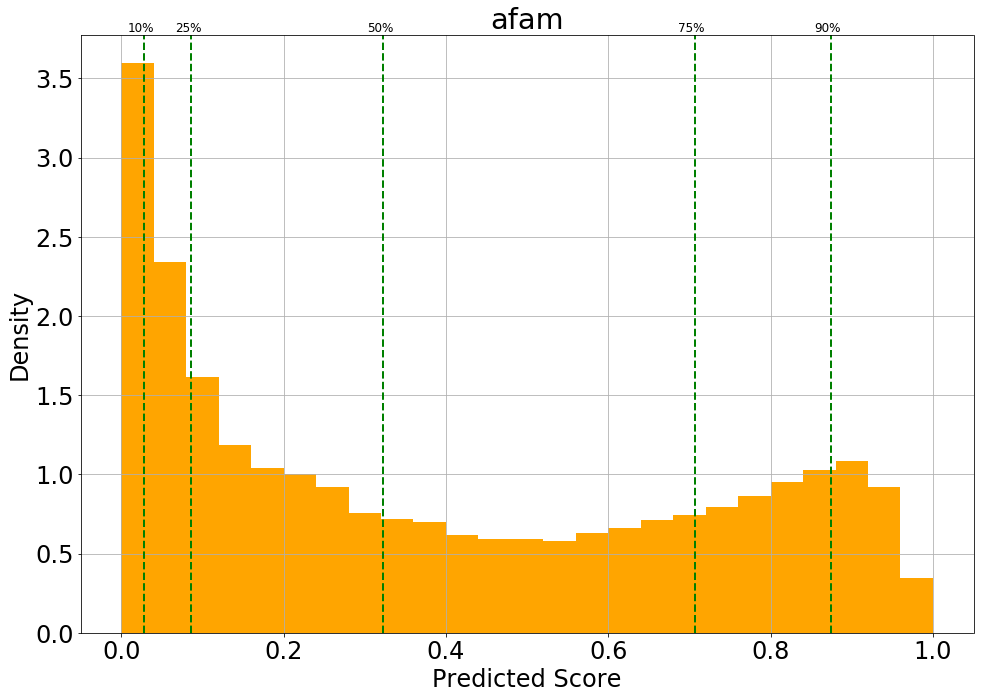

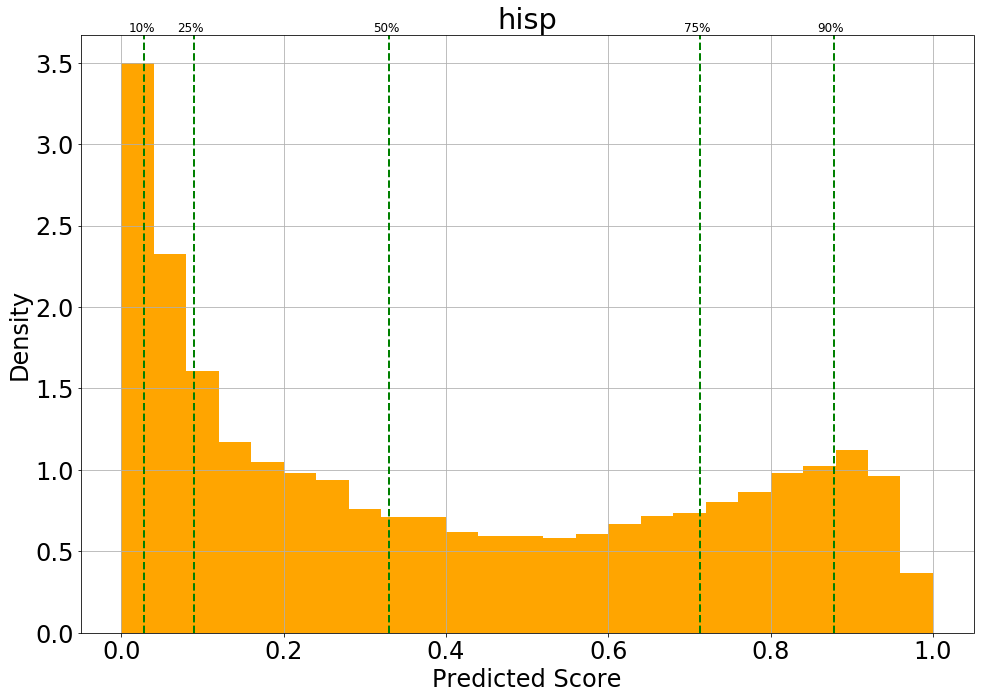

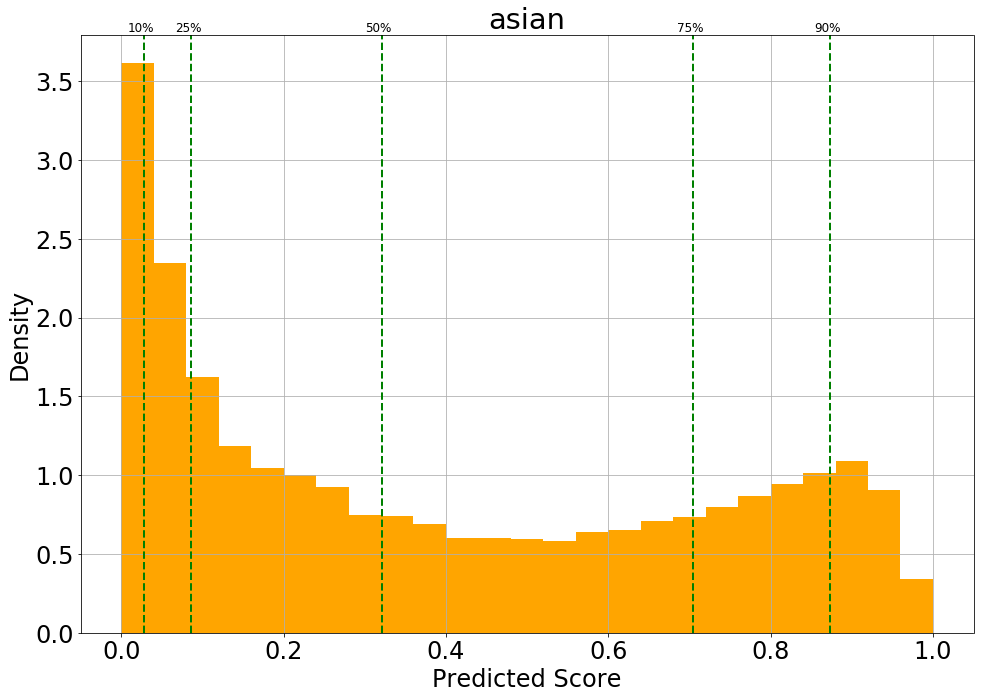

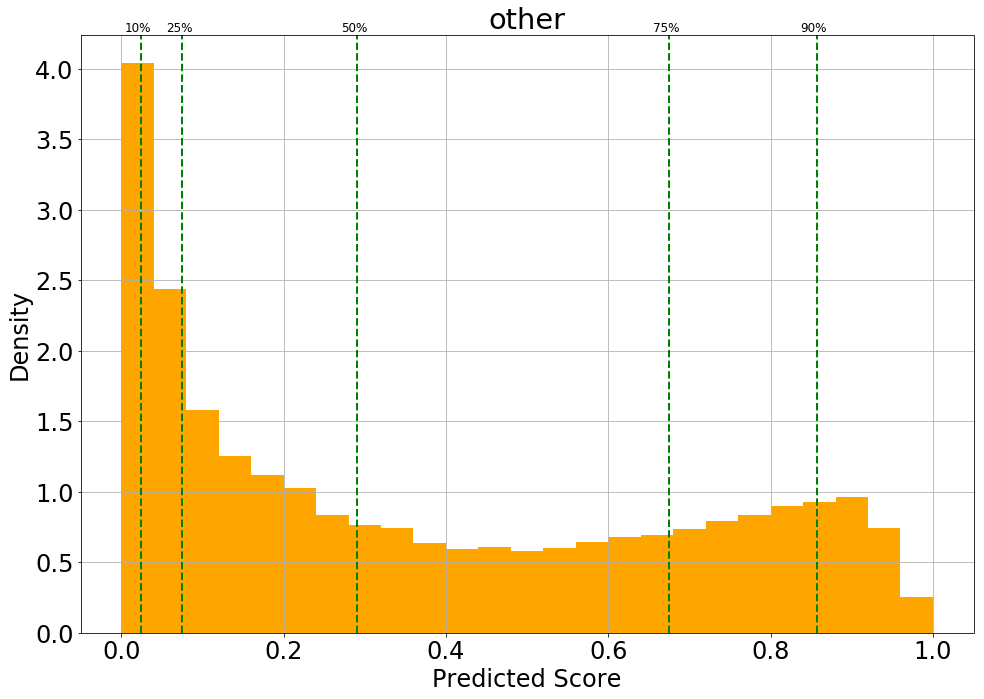

In [49]:
y_test_pred_dict = {}
test_df_white = test_df_new[test_df_new.white == 1]
y_test_pred_dict['white'] = list(lr.predict(add_constant(test_df_white.loc[:,predictors], prepend=True, has_constant='add')))
success_rate_2 = [('white', np.mean(np.array(y_test_pred_dict['white']) > best_threshold))]
for r in ['afam', 'hisp', 'asian', 'other']:
    test_df_fake = test_df_white.copy()
    test_df_fake.loc[:,'white'] = 0
    test_df_fake.loc[:,r] = 1
    y_test_pred_dict[r] = list(lr.predict(add_constant(test_df_fake.loc[:,predictors], prepend=True, has_constant='add')))
    success_rate_2.append((r, np.mean(np.array(y_test_pred_dict[r]) > best_threshold)))
    y_arr = np.array(y_test_pred_dict[r])
    fig = plt.figure(figsize=(16,11)) 
    ax = fig.add_subplot(1, 1, 1)
    pd.DataFrame({r:y_arr}).hist(r, bins = np.linspace(0,1,26), density=True, color='orange', figsize=(16,11), ax=ax)
    for p,q in zip(np.percentile(y_arr, q = [10,25,50,75,90]), [10,25,50,75,90]):
        ax.axvline(x=p, color='g', linestyle='dashed', linewidth=2)
        ax.text(p-0.02,ax.get_ylim()[1]*1.005,"{}%".format(q),fontsize=12)
    ax.set_xlabel("Predicted Score")
    ax.set_ylabel("Density")
    plt.savefig(results_dir + r +"_2.png")
    plt.show()

In [50]:
n = success_rate_1[1][1]
p1 = success_rate_2[0][1]
psr_pval = []
for i in range(1, len(success_rate_2)):
    subgp = success_rate_2[i][0]
    p2 = success_rate_2[i][1]
    psr_pval.append((subgp, two_side_z_test(n,p1,n,p2)))

In [51]:
pd.DataFrame(success_rate_2, columns=['subgroup', 'pred_success_rate'])\
.merge(pd.DataFrame(psr_pval, columns=['subgroup', 'p-value_for_pred_success_rate']), on=['subgroup'], how='left')\
.loc[:,['subgroup', 'pred_success_rate', 'p-value_for_pred_success_rate']]\
.round(4).to_csv(results_dir + "success_rate_2.csv", index=False)

In [52]:
race_column = []
for i in range(test_df.shape[0]):
    if test_df.white.iloc[i] == 1:
        race_column.append("white")
    elif test_df.afam.iloc[i] == 1:
        race_column.append("afam")
    elif test_df.hisp.iloc[i] == 1:
        race_column.append("hisp")
    elif test_df.asian.iloc[i] == 1:
        race_column.append("asian")
    elif test_df.other.iloc[i] == 1:
        race_column.append("other")
    else:
        race_column.append("mi")
race_column = np.array(race_column)
pred_y = np.array(y_test_pred_lr)
test_y = np.array(test_df.grad_6years)
pred_y = pred_y[race_column != "mi"]
test_y = test_y[race_column != "mi"]
race_column = race_column[race_column != "mi"]
print(len(race_column), len(pred_y), len(test_y))

62049 62049 62049


In [53]:
def ba_auc(subgp):
    l2 = pred_y
    l3 = test_y
    indices = np.where(np.array(race_column) == subgp)[0]
    l2_sub = l2[indices]
    l3_sub = l3[indices]
    return roc_auc_score(l3_sub, l2_sub)

results_auc = []
for gp in ['white', 'afam', 'hisp', 'asian', 'other']:
    results_auc.append((gp, ba_auc(gp)))
    
results_auc_df = pd.DataFrame(results_auc, columns = ['subgroup', 'c-statistic']).round(4)
results_auc_df.to_csv(results_dir + "bias_cstat.csv", index=False)

In [54]:
pred_score_by_race = pd.DataFrame({'race_column': race_column, 'pred_y': pred_y, 'test_y': test_y})
pred_score_by_race.to_csv(results_dir + "pred_score_by_race.csv", index=False)

In [55]:
def ba_0(subgp):
    l2 = pred_y
    l3 = test_y
    indices = np.where(np.array(race_column) == subgp)[0]
    l2_sub = l2[indices]
    l3_sub = l3[indices]
    N1 = sum(l2_sub <= best_threshold)
    N2 = sum(l3_sub == 0)
    a1 = 1-np.mean(l3_sub[l2_sub <= best_threshold]) #precision_0
    a2 = np.mean(l2_sub[l3_sub == 0] > best_threshold) #false positive rate
    return subgp, N1, a1, N2, a2

results_0 = []
for gp in ['white', 'afam', 'hisp', 'asian', 'other']:
    results_0.append(ba_0(gp))

In [56]:
def ba_1(subgp):
    l2 = pred_y
    l3 = test_y
    indices = np.where(np.array(race_column) == subgp)[0]
    l2_sub = l2[indices]
    l3_sub = l3[indices]
    N = sum(l3_sub == 0)
    a = np.mean(l2_sub[l3_sub == 1] > best_threshold) #true positive rate
    return subgp, N, a

results_1 = []
for gp in ['white', 'afam', 'hisp', 'asian', 'other']:
    results_1.append(ba_1(gp))

In [57]:
def ba_bas(subgp):
    l2 = pred_y
    l3 = test_y
    indices = np.where(np.array(race_column) == subgp)[0]
    l2_sub = l2[indices]
    l3_sub = l3[indices]
    N = len(indices)
    a = balanced_accuracy_score(l3_sub, np.where(l2_sub > best_threshold, 1, 0))
    return subgp, N, a

results_bas = []
for gp in ['white', 'afam', 'hisp', 'asian', 'other']:
    results_bas.append(ba_bas(gp))

In [58]:
def ba_pred_score(subgp):
    l2 = pred_y
    l3 = test_y
    indices = np.where(np.array(race_column) == subgp)[0]
    l2_sub = l2[indices]
    l3_sub = l3[indices]
    sr = np.mean(l3)
    N = len(indices)
    a = np.mean(l2_sub) - sr
    return subgp, N, a, np.var(l2_sub)  

results_pred_score = []
for gp in ['white', 'afam', 'hisp', 'asian', 'other']:
    results_pred_score.append(ba_pred_score(gp))

In [59]:
y_train_pred_lr = list(lr.predict(add_constant(X_train, prepend=True)))

In [60]:
race_column_train = []
for i in range(train_df.shape[0]):
    if train_df.white.iloc[i] == 1:
        race_column_train.append("white")
    elif train_df.afam.iloc[i] == 1:
        race_column_train.append("afam")
    elif train_df.hisp.iloc[i] == 1:
        race_column_train.append("hisp")
    elif train_df.asian.iloc[i] == 1:
        race_column_train.append("asian")
    elif train_df.other.iloc[i] == 1:
        race_column_train.append("other")
    else:
        race_column_train.append("mi")
race_column_train = np.array(race_column_train)
pred_y_train = np.array(y_train_pred_lr)
test_y_train = np.array(train_df.grad_6years)
pred_y_train = pred_y_train[race_column_train != "mi"]
test_y_train = test_y_train[race_column_train != "mi"]
race_column_train = race_column_train[race_column_train != "mi"]
print(len(race_column_train), len(pred_y_train), len(test_y_train))

316126 316126 316126


In [61]:
def ba_pred_score_train(subgp):
    l2 = pred_y_train
    l3 = test_y_train
    indices = np.where(np.array(race_column_train) == subgp)[0]
    l2_sub = l2[indices]
    l3_sub = l3[indices]
    sr = np.mean(l3)
    N = len(indices)
    a = np.mean(l2_sub) - sr
    return subgp, N, a, np.var(l2_sub)  

results_pred_score_train = []
for gp in ['white', 'afam', 'hisp', 'asian', 'other']:
    results_pred_score_train.append(ba_pred_score_train(gp))

In [62]:
n1 = results_1[0][1]
p1 = results_1[0][2]
tpr_pval = []
for i in range(1, len(results_1)):
    subgp = results_1[i][0]
    n2 = results_1[i][1]
    p2 = results_1[i][2]
    tpr_pval.append((subgp, two_side_z_test(n1,p1,n2,p2)))
        
n1 = results_0[0][1]
p1 = results_0[0][2]
precision0_pval = []
for i in range(1, len(results_0)):
    subgp = results_0[i][0]
    n2 = results_0[i][1]
    p2 = results_0[i][2]
    precision0_pval.append((subgp, two_side_z_test(n1,p1,n2,p2)))
        
n1 = results_0[0][3]
p1 = results_0[0][4]
fpr_pval = []
for i in range(1, len(results_0)):
    subgp = results_0[i][0]
    n2 = results_0[i][3]
    p2 = results_0[i][4]
    fpr_pval.append((subgp, two_side_z_test(n1,p1,n2,p2)))
    
n1 = results_bas[0][1]
p1 = results_bas[0][2]
bas_pval = []
for i in range(1, len(results_bas)):
    subgp = results_bas[i][0]
    n2 = results_bas[i][1]
    p2 = results_bas[i][2]
    bas_pval.append((subgp, two_side_z_test(n1,p1,n2,p2)))
    
n1 = results_pred_score[0][1]
p1 = results_pred_score[0][2]
v1 = results_pred_score[0][3]
pred_score_pval = []
for i in range(1, len(results_pred_score)):
    subgp = results_pred_score[i][0]
    n2 = results_pred_score[i][1]
    p2 = results_pred_score[i][2]
    v2 = results_pred_score[i][3]
    pred_score_pval.append((subgp, two_side_z_test_2(n1,p1,v1,n2,p2,v2)))

In [63]:
n1 = results_pred_score_train[0][1]
p1 = results_pred_score_train[0][2]
v1 = results_pred_score_train[0][3]
pred_score_pval_train = []
for i in range(1, len(results_pred_score_train)):
    subgp = results_pred_score_train[i][0]
    n2 = results_pred_score_train[i][1]
    p2 = results_pred_score_train[i][2]
    v2 = results_pred_score_train[i][3]
    pred_score_pval_train.append((subgp, two_side_z_test_2(n1,p1,v1,n2,p2,v2)))

In [64]:
results_tpr_df = pd.DataFrame(results_1, columns=['subgroup', 'N', 'true_positive_rate']).drop(['N'], axis=1).\
merge(pd.DataFrame(tpr_pval, columns = ['subgroup', 'p-value']), on=['subgroup'], how='left').round(4)
results_tpr_df.to_csv(results_dir + "bias_tpr.csv", index=False)

In [65]:
results_fpr_df = pd.DataFrame(results_0, columns=['subgroup', 'N1', 'precision0', 'N2', 'false_positive_rate']).drop(['N1','precision0','N2'], axis=1).\
merge(pd.DataFrame(fpr_pval, columns = ['subgroup', 'p-value']), on=['subgroup'], how='left').round(4)
results_fpr_df.to_csv(results_dir + "bias_fpr.csv", index=False)

In [66]:
results_precision0_df = pd.DataFrame(results_0, columns=['subgroup', 'N1', 'precision0', 'N2', 'false_positive_rate']).drop(['N1','N2','false_positive_rate'], axis=1).\
merge(pd.DataFrame(precision0_pval, columns = ['subgroup', 'p-value']), on=['subgroup'], how='left').round(4)
results_precision0_df.to_csv(results_dir + "bias_precision0.csv", index=False)

In [67]:
results_bas_df = pd.DataFrame(results_bas, columns=['subgroup', 'N', 'balanced_accuracy_score']).drop(['N'], axis=1).\
merge(pd.DataFrame(bas_pval, columns = ['subgroup', 'p-value']), on=['subgroup'], how='left').round(4)
results_bas_df.to_csv(results_dir + "bias_bas.csv", index=False)

In [68]:
results_pred_score_df = pd.DataFrame(results_pred_score, columns=['subgroup', 'N', 'mean_pred_score', 'var_pred_score']).drop(['N', 'var_pred_score'], axis=1).\
merge(pd.DataFrame(pred_score_pval, columns = ['subgroup', 'p-value']), on=['subgroup'], how='left').round(4)
results_pred_score_df.to_csv(results_dir + "bias_pred_score.csv", index=False)

In [69]:
results_pred_score_train_df = pd.DataFrame(results_pred_score_train, columns=['subgroup', 'N', 'mean_pred_score', 'var_pred_score']).drop(['N', 'var_pred_score'], axis=1).\
merge(pd.DataFrame(pred_score_pval_train, columns = ['subgroup', 'p-value']), on=['subgroup'], how='left').round(4)
results_pred_score_train_df.to_csv(results_dir + "bias_pred_score_train.csv", index=False)

#### Check predictive parity

In [70]:
new_pred_real = pd.DataFrame({'pred_y': pred_y,'real_y': test_y, 'race': race_column})
new_pred_real.loc[:,'pred_y_binned'] = pd.cut(new_pred_real.pred_y, bins=[0] + list(np.percentile(new_pred_real.pred_y, np.arange(2,100,2))) + [1])
new_pred_real.loc[:,'pred_y_binned_2'] = pd.cut(new_pred_real.pred_y, bins=[0] + list(np.percentile(new_pred_real.pred_y, np.arange(10,100,10))) + [1])

In [71]:
pct_dict = {e:(10*indx+5) for indx, e in enumerate(sorted(np.unique(new_pred_real.pred_y_binned_2)))}

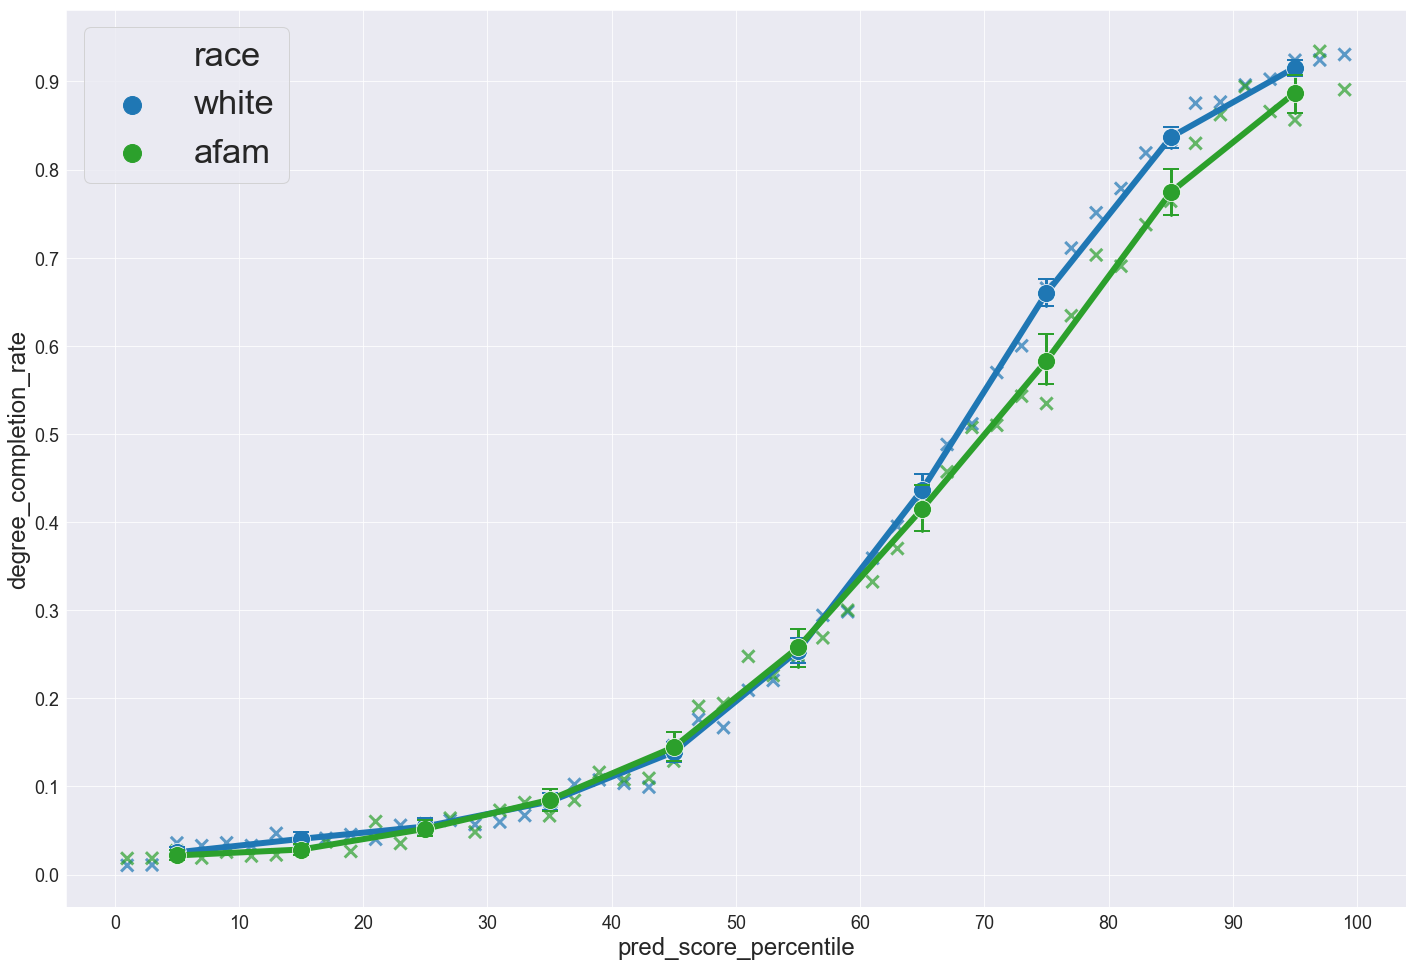

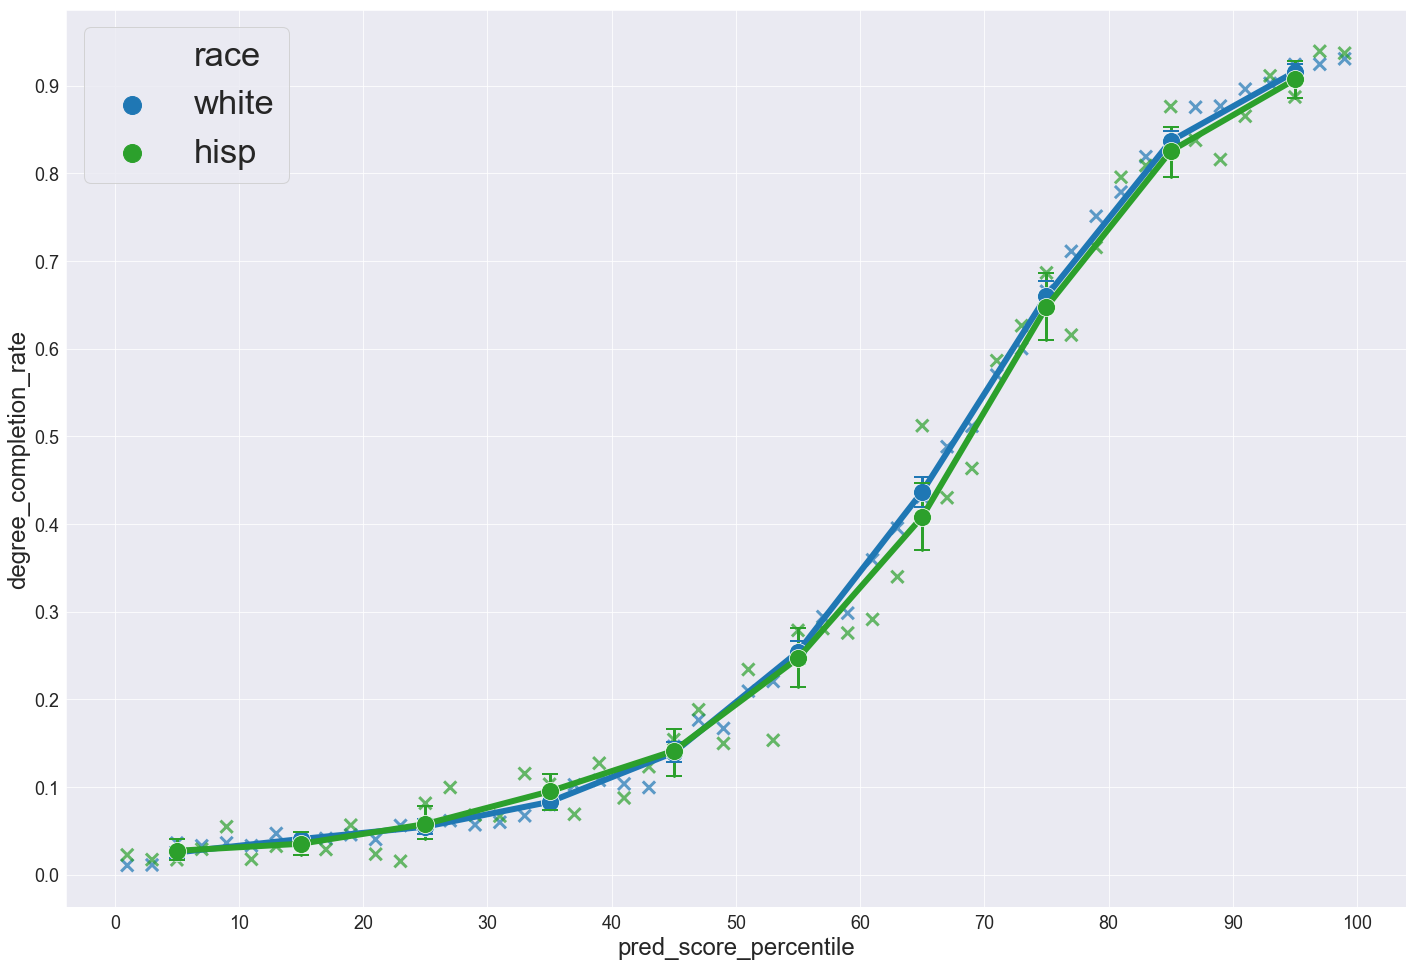

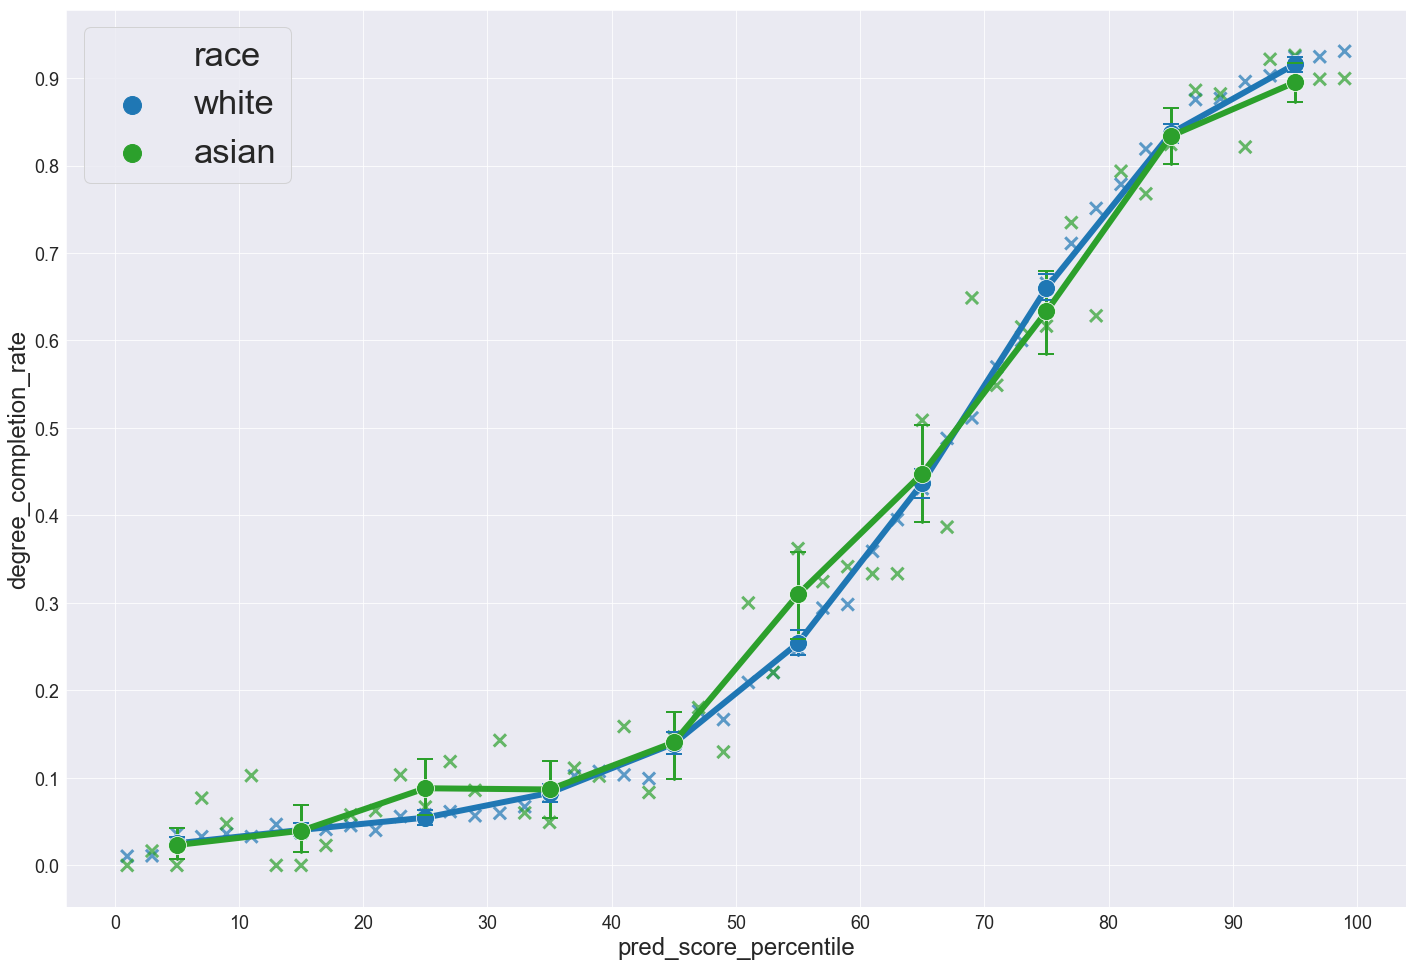

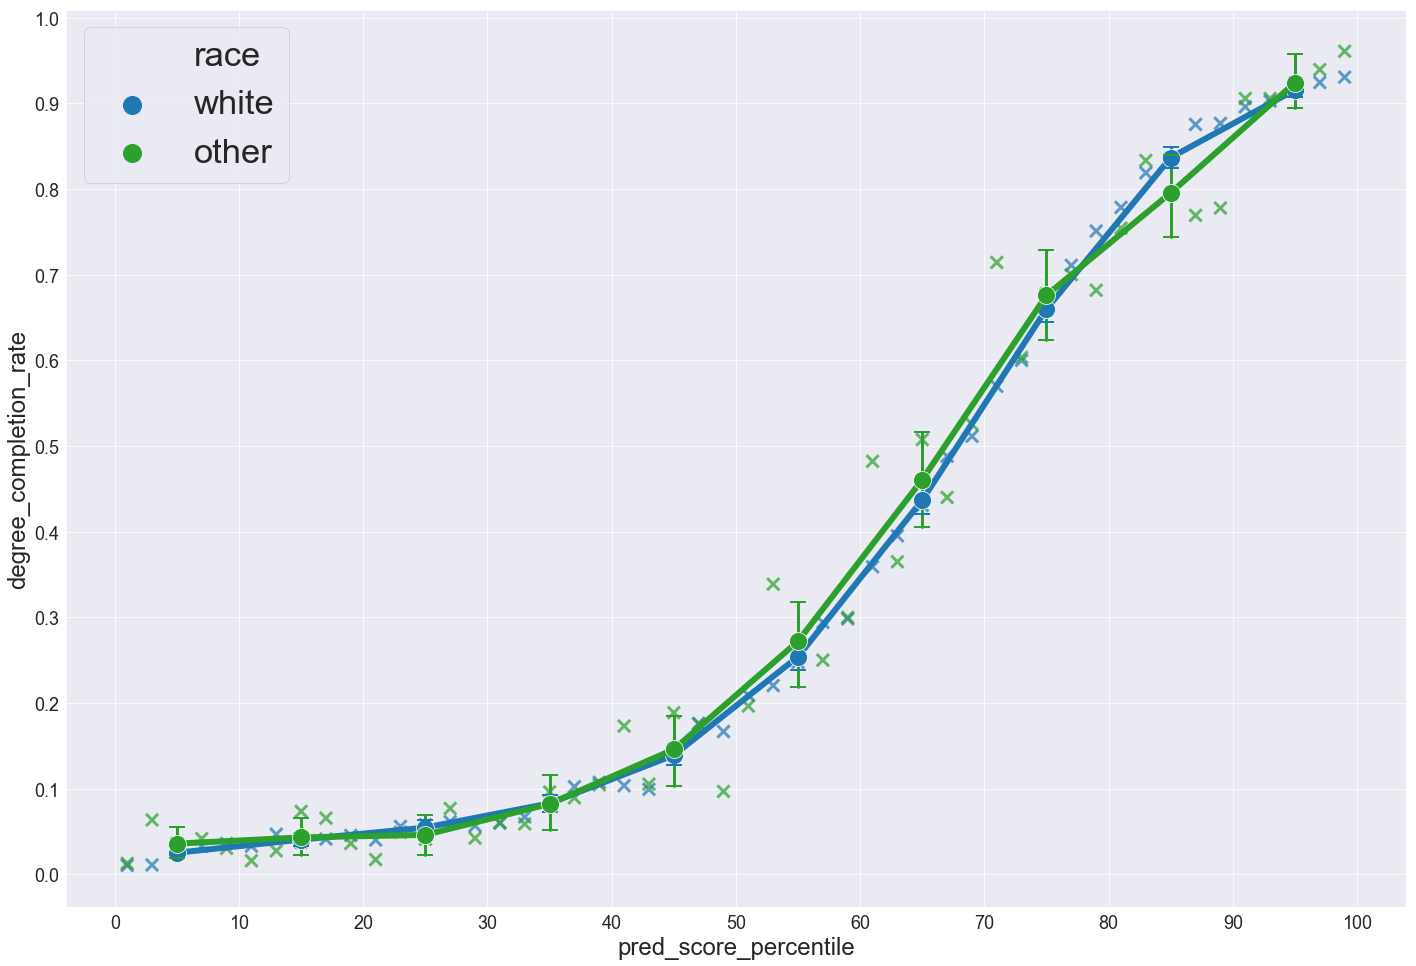

In [72]:
for r in ['afam', 'hisp', 'asian', 'other']:
    
    new_sub = new_pred_real.copy()[new_pred_real.race.apply(lambda x: x in ['white', r])]
    new_sub.loc[:,r] = new_sub.race.apply(lambda x: 1 if x == r else 0)
    new_sub = new_sub.groupby(['pred_y_binned', 'race', r]).agg({'real_y':'mean'}).reset_index()
    new_sub = new_sub.sort_values([r, 'pred_y_binned'])
    new_sub.loc[:,'pred_score_percentile'] = list(np.linspace(1,99,50))*2
    new_sub = new_sub.rename(columns={'real_y':'degree_completion_rate'}).drop(['pred_y_binned'], axis=1)

    sns.set_style(style = "darkgrid")
    fig, ax = plt.subplots(1,1, figsize=(24,16.5))
    sns.scatterplot(x="pred_score_percentile", y="degree_completion_rate", hue='race', hue_order = ['white', r],
                    data=new_sub,
                    palette = ['C0','C2'], marker="x", ax=ax, s=150, alpha=0.7, linewidth = 3)
    ax.legend(fontsize='x-large', title_fontsize='40', markerscale=3)
    plt.xticks(np.linspace(0,100, 11),fontsize=18)
    plt.yticks(np.linspace(0,1,11),fontsize=18)
    
    new_sub = new_pred_real.copy()[new_pred_real.race.apply(lambda x: x in ['white', r])]
    new_sub.loc[:,'pred_score_percentile_new'] = new_sub.pred_y_binned_2.apply(lambda x: pct_dict[x])
    np.random.seed(4321)
    sns.lineplot(data=new_sub, x="pred_score_percentile_new", y="real_y", hue='race', hue_order = ['white', r],
                 err_style="bars", err_kws = {'capsize': 8, 'elinewidth':3, 'capthick':2}, 
                 ci=95, ax=ax, linewidth = 6,
                 palette = ['C0','C2'], legend=False,
                 marker=".", markersize=36)
    plt.xlabel("pred_score_percentile", fontsize=24)
    plt.ylabel("degree_completion_rate", fontsize=24)
    
    plt.savefig(results_dir + r +"_predictive_parity.png")
    plt.show()

In [73]:
new_sub_list = []
for r in ['white', 'afam', 'hisp', 'asian', 'other']:
    new_sub = new_pred_real.copy()[new_pred_real.race == r]
    new_sub.loc[:,'pred_score_percentile_new'] = new_sub.pred_y_binned_2.apply(lambda x: pct_dict[x])
    new_sub = new_sub[new_sub.pred_score_percentile_new.apply(lambda x: x in {15,55,85})]
    new_sub = new_sub.groupby(['pred_score_percentile_new']).agg({'real_y': ['count', 'mean']}).reset_index()
    new_sub = new_sub[new_sub[('real_y', 'count')] != 0]
    new_sub.columns = ['percentile', 'N', 'mean']
    new_sub.loc[:,'race'] = r
    new_sub_list.append(new_sub.copy())
new_sub_all = pd.concat(new_sub_list)

In [74]:
for p in [15,55,85]:
    sub = new_sub_all[new_sub_all.percentile == p].copy()
    p_val_list = [np.nan]
    n1 = sub.N.iloc[0]
    p1 = sub['mean'].iloc[0]
    for i in range(1,sub.shape[0]):
        n2 = sub.N.iloc[i]
        p2 = sub['mean'].iloc[i]
        p_val_list.append(two_side_z_test(n1,p1,n2,p2))
    sub.loc[:,'p-value'] = p_val_list
    sub = sub.loc[:,['race', 'N', 'mean','p-value']].rename(columns={'mean':'degree_completion_rate'}).round(4)
    sub.to_csv(results_dir + "predictive_parity_pct_{}.csv".format(p), index=False)

In [75]:
white_df = new_pred_real[new_pred_real.race == "white"]
white_df = white_df.iloc[np.argsort(white_df.pred_y), :]
afam_df = new_pred_real[new_pred_real.race == "afam"]
afam_df = afam_df.iloc[np.argsort(afam_df.pred_y), :]

In [76]:
white_df.shape[0], afam_df.shape[0]

(32288, 16796)

In [78]:
results = []
for qq in [0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6, 0.67, 0.7, 0.75, 0.8, 0.9]:
    print("qq = {}".format(qq))
    q = np.quantile(new_pred_real.pred_y, qq)
    new_pred_real_pct = new_pred_real[new_pred_real.pred_y < q]
    new_pred_real_pct = new_pred_real_pct[new_pred_real_pct.race.apply(lambda x: x in {'white', 'afam'})]
    new_pred_real_pct_agg = new_pred_real_pct.groupby(['race']).agg({'real_y': 'mean', 'pred_y': 'count'}).sort_index().loc[:,['real_y', 'pred_y']]
    n1, p1 = new_pred_real_pct_agg.iloc[0,1], new_pred_real_pct_agg.iloc[0,0]
    n2, p2 = new_pred_real_pct_agg.iloc[1,1], new_pred_real_pct_agg.iloc[1,0]
    p_value_1 = two_side_z_test(n1, p1, n2, p2)
    ratio_1 = n1 / n2
    pp1, pp2 = 0, 1
    j = 1
    # while p_value < 0.05:
    while pp1 < pp2 and j < n2 and n1 + j <= afam_df.shape[0]:
        j += 1
        white_df_new = white_df.iloc[0:(n2-j),:]
        afam_df_new = afam_df.iloc[0:(n1+j),:]
        merged_new = pd.concat([white_df_new, afam_df_new])
        merged_new_agg = merged_new.groupby(['race']).agg({'real_y': 'mean', 'pred_y': 'count'}).sort_index().loc[:,['real_y', 'pred_y']]
        nn1, pp1 = merged_new_agg.iloc[0,1], merged_new_agg.iloc[0,0]
        nn2, pp2 = merged_new_agg.iloc[1,1], merged_new_agg.iloc[1,0]
    p_value_2 = two_side_z_test(nn1, pp1, nn2, pp2)
    ratio_2 = nn1/nn2
    results.append((int(qq*100), p1, p2, n1, n2, pp1, pp2, nn1, nn2))

qq = 0.1
qq = 0.2
qq = 0.25
qq = 0.3
qq = 0.33
qq = 0.4
qq = 0.5
qq = 0.6
qq = 0.67
qq = 0.7
qq = 0.75
qq = 0.8
qq = 0.9


In [81]:
results_df = \
pd.DataFrame(results, columns=["bottom_%", 
                               "success_rate_black", "success_rate_white", "n1","n2"
                               "success_rate_black", "success_rate_white", "nn1","nn2",
                               "black_increased"]).sort_values(["bottom_%"]).round(4)
results_df.to_csv("C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\bias\\new\\calibration_bias.csv", index=False)

In [82]:
def std_new(p,n):
    return np.sqrt(p*(1-p)/n)

In [83]:
results = []
for qq in [0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6, 0.67, 0.7, 0.75, 0.8, 0.9]:
    print("qq = {}".format(qq))
    q = np.quantile(new_pred_real.pred_y, qq)
    new_pred_real_pct = new_pred_real[new_pred_real.pred_y < q]
    new_pred_real_pct = new_pred_real_pct[new_pred_real_pct.race.apply(lambda x: x in {'white', 'afam'})]
    new_pred_real_pct_agg = new_pred_real_pct.groupby(['race']).agg({'real_y': 'mean', 'pred_y': 'count'}).sort_index().loc[:,['real_y', 'pred_y']]
    n1, p1 = new_pred_real_pct_agg.iloc[0,1], 1 - new_pred_real_pct_agg.iloc[0,0]
    n2, p2 = new_pred_real_pct_agg.iloc[1,1], 1 - new_pred_real_pct_agg.iloc[1,0]
    std1 = std_new(p1, n1)
    std2 = std_new(p2, n2)
    white = new_pred_real[np.array(new_pred_real.race == "white") & np.array(new_pred_real.real_y == 0)]
    afam = new_pred_real[np.array(new_pred_real.race == "afam") & np.array(new_pred_real.real_y == 0)]
    n3 = white.shape[0]
    n4 = afam.shape[0]
    p3 = np.mean(white.pred_y < q)
    p4 = np.mean(afam.pred_y < q)
    std3 = std_new(p3, n3)
    std4 = std_new(p4, n4)
    results.append((qq, p1, std1, p2, std2, p3, std3, p4, std4))

qq = 0.1
qq = 0.2
qq = 0.25
qq = 0.3
qq = 0.33
qq = 0.4
qq = 0.5
qq = 0.6
qq = 0.67
qq = 0.7
qq = 0.75
qq = 0.8
qq = 0.9


In [84]:
results_df = \
pd.DataFrame(results, columns=["bottom_%", 
                               "black", "std_black",
                               "white", "std_white",
                               "black", "std_black",
                               "white", "std_white"]).sort_values(["bottom_%"]).round(4)
results_df.to_csv("C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\bias\\new\\tnr_precision0_bias_full.csv", index=False)